In [11]:
import os
print("Logical CPU cores:", os.cpu_count())
import psutil
print("Physical CPU cores:", psutil.cpu_count(logical=False))
print("Logical CPU cores: ", psutil.cpu_count(logical=True))


Logical CPU cores: 16
Physical CPU cores: 10
Logical CPU cores:  16


In [12]:
## 1. 라이브러리 불러오기

import pickle
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import copy
import random

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

# 랜덤 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치: {device}")

print("기본 라이브러리 로드 완료")


사용 장치: cuda
기본 라이브러리 로드 완료


In [13]:
import torch

# GPU 상태 테스트
print("GPU 테스트 시작")
if torch.cuda.is_available():
    # 랜덤 텐서 생성
    x = torch.randn(1000, 1000).cuda()
    y = torch.randn(1000, 1000).cuda()
    
    # 행렬 곱
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)
    
    start_time.record()
    z = torch.matmul(x, y)
    end_time.record()
    
    # CUDA 이벤트 동기화
    torch.cuda.synchronize()
    
    print(f"행렬 곱셈 시간: {start_time.elapsed_time(end_time):.2f} ms")
    print("GPU가 정상 작동합니다!")
else:
    print("GPU를 사용할 수 없습니다.")

GPU 테스트 시작
행렬 곱셈 시간: 2.48 ms
GPU가 정상 작동합니다!


In [14]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
    # 실제로 텐서를 GPU로 옮겨 볼게요
    x = torch.randn(1000, 1000)
    x_cuda = x.to("cuda")
    print("x_cuda device:", x_cuda.device)

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU
x_cuda device: cuda:0
PyTorch version: 2.5.1+cu124
CUDA version: 12.4
cuDNN version: 90100


In [15]:
## 2. 데이터 로드

# 데이터 경로 설정
PROCESSED_DIR = "./data/processed"
EMBEDDINGS_DIR = "./data/embeddings"
TRUST_DIR = "./data/trust"
MODELS_DIR = "./models"

# 디렉토리 생성
os.makedirs(MODELS_DIR, exist_ok=True)

# 전처리된 데이터 로드
data_files = {
    'train_df': os.path.join(PROCESSED_DIR, 'train_df.pkl'),
    'val_df': os.path.join(PROCESSED_DIR, 'val_df.pkl'),
    'test_df': os.path.join(PROCESSED_DIR, 'test_df.pkl'),
    'train_with_neg': os.path.join(PROCESSED_DIR, 'train_with_neg.pkl'),
    'user_processed': os.path.join(PROCESSED_DIR, 'user_processed.pkl'),
    'business_processed': os.path.join(PROCESSED_DIR, 'business_processed.pkl')
}

# 데이터 로드
data = {}
for name, file_path in data_files.items():
    with open(file_path, 'rb') as f:
        data[name] = pickle.load(f)
    print(f"{name} 로드 완료: {len(data[name]):,}개 항목")

# 임베딩 데이터 로드
embedding_files = {
    'train_item_embeddings': os.path.join(EMBEDDINGS_DIR, 'train_item_embeddings.pkl'),
    'val_item_embeddings': os.path.join(EMBEDDINGS_DIR, 'val_item_embeddings.pkl'),
    'test_item_embeddings': os.path.join(EMBEDDINGS_DIR, 'test_item_embeddings.pkl'),
    'train_user_embeddings': os.path.join(EMBEDDINGS_DIR, 'train_user_embeddings.pkl'),
    'val_user_embeddings': os.path.join(EMBEDDINGS_DIR, 'val_user_embeddings.pkl'),
    'test_user_embeddings': os.path.join(EMBEDDINGS_DIR, 'test_user_embeddings.pkl'),
    'enhanced_item_embeddings': os.path.join(EMBEDDINGS_DIR, 'enhanced_item_embeddings.pkl')
}

## 신뢰도 가중치 함수 정의
def trust_weight_linear(trust_score):
    """
    선형 신뢰도 가중치 함수
    
    Args:
        trust_score (float): 신뢰도 점수 (0-1)
        
    Returns:
        float: 가중치 (0.5-1.5)
    """
    # 신뢰도 점수에 따라 0.5에서 1.5 사이의 가중치 반환
    return 0.5 + trust_score * 1.0

def trust_weight_sigmoid(trust_score, k=10):
    """
    시그모이드 신뢰도 가중치 함수
    
    Args:
        trust_score (float): 신뢰도 점수 (0-1)
        k (float): 시그모이드 기울기
        
    Returns:
        float: 가중치 (0.5-1.5)
    """
    # 시그모이드 함수를 사용하여 0.5에서 1.5 사이의 가중치 반환
    x = (trust_score - 0.5) * k
    sigmoid = 1 / (1 + np.exp(-x))
    return 0.5 + sigmoid * 1.0

def trust_weight_step(trust_score, steps=4):
    """
    계단식 신뢰도 가중치 함수
    
    Args:
        trust_score (float): 신뢰도 점수 (0-1)
        steps (int): 계단 수
        
    Returns:
        float: 가중치 (0.5-1.5)
    """
    # 계단식 함수를 사용하여 0.5에서 1.5 사이의 가중치 반환
    step_size = 1.0 / steps
    step = int(trust_score / step_size)
    step = min(step, steps - 1)  # 최대 계단 수 제한
    return 0.5 + step * (1.0 / (steps - 1))

# 임베딩 로드
embeddings = {}
for name, file_path in embedding_files.items():
    with open(file_path, 'rb') as f:
        embeddings[name] = pickle.load(f)
    print(f"{name} 로드 완료: {len(embeddings[name]):,}개 항목")

# 신뢰도 점수 데이터 로드
with open(os.path.join(TRUST_DIR, 'user_trust_scores.pkl'), 'rb') as f:
    user_trust_scores = pickle.load(f)
print(f"사용자 신뢰도 점수 로드 완료: {len(user_trust_scores):,}개 항목")

# 신뢰도 가중치 함수 로드
with open(os.path.join(TRUST_DIR, 'trust_weight_functions.pkl'), 'rb') as f:
    trust_weight_functions = pickle.load(f)
print(f"신뢰도 가중치 함수 로드 완료: {len(trust_weight_functions):,}개 함수")

# 변수에 할당
train_df = data['train_df']
val_df = data['val_df']
test_df = data['test_df']
train_with_neg = data['train_with_neg']
user_processed = data['user_processed']
business_processed = data['business_processed']

train_item_embeddings = embeddings['train_item_embeddings']
val_item_embeddings = embeddings['val_item_embeddings']
test_item_embeddings = embeddings['test_item_embeddings']
train_user_embeddings = embeddings['train_user_embeddings']
val_user_embeddings = embeddings['val_user_embeddings']
test_user_embeddings = embeddings['test_user_embeddings']
enhanced_item_embeddings = embeddings['enhanced_item_embeddings']

# 사용할 신뢰도 가중치 함수 선택
trust_weight_fn = trust_weight_functions['sigmoid']  # 시그모이드 가중치 함수 사용

# 데이터셋 확인
print(f"\n훈련 세트 크기: {len(train_df):,}")
print(f"검증 세트 크기: {len(val_df):,}")
print(f"테스트 세트 크기: {len(test_df):,}")
print(f"부정적 샘플 포함 훈련 세트 크기: {len(train_with_neg):,}")

train_df 로드 완료: 20,674개 항목
val_df 로드 완료: 4,128개 항목
test_df 로드 완료: 1,748개 항목
train_with_neg 로드 완료: 22,906개 항목
user_processed 로드 완료: 430개 항목
business_processed 로드 완료: 7,044개 항목
train_item_embeddings 로드 완료: 3,486개 항목
val_item_embeddings 로드 완료: 1,806개 항목
test_item_embeddings 로드 완료: 1,106개 항목
train_user_embeddings 로드 완료: 18,129개 항목
val_user_embeddings 로드 완료: 4,118개 항목
test_user_embeddings 로드 완료: 1,738개 항목
enhanced_item_embeddings 로드 완료: 3,486개 항목
사용자 신뢰도 점수 로드 완료: 430개 항목
신뢰도 가중치 함수 로드 완료: 3개 함수

훈련 세트 크기: 20,674
검증 세트 크기: 4,128
테스트 세트 크기: 1,748
부정적 샘플 포함 훈련 세트 크기: 22,906


In [16]:
## 3. 데이터셋 및 DataLoader 구현

class YelpDataset(Dataset):
    """
    Yelp 데이터셋 클래스
    """
    def __init__(self, interactions_df, user_embeddings, item_embeddings, 
                 user_trust_scores=None, trust_weight_fn=None, 
                 use_text_embeddings=True):
        """
        Args:
            interactions_df (pd.DataFrame): 상호작용 데이터프레임
            user_embeddings (dict): 사용자 임베딩 딕셔너리
            item_embeddings (dict): 아이템 임베딩 딕셔너리
            user_trust_scores (pd.DataFrame): 사용자 신뢰도 점수 데이터프레임
            trust_weight_fn (callable): 신뢰도 가중치 함수
            use_text_embeddings (bool): 텍스트 임베딩 사용 여부
        """
        self.interactions = interactions_df
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings
        self.user_trust_scores = user_trust_scores
        self.trust_weight_fn = trust_weight_fn
        self.use_text_embeddings = use_text_embeddings
        
        # 임베딩 차원 확인
        if len(user_embeddings) > 0:
            self.user_embed_dim = len(next(iter(user_embeddings.values())))
        else:
            self.user_embed_dim = 0
            
        if len(item_embeddings) > 0:
            self.item_embed_dim = len(next(iter(item_embeddings.values())))
        else:
            self.item_embed_dim = 0
            
        # 고유 사용자 및 아이템 수 계산
        self.num_users = interactions_df['user_idx'].nunique()
        self.num_items = interactions_df['item_idx'].nunique()
        
        print(f"데이터셋 정보:")
        print(f"  상호작용 수: {len(interactions_df):,}")
        print(f"  사용자 수: {self.num_users:,}")
        print(f"  아이템 수: {self.num_items:,}")
        
    def __len__(self):
        return len(self.interactions)
    
    def __getitem__(self, idx):
        interaction = self.interactions.iloc[idx]
        user_idx = interaction['user_idx']
        item_idx = interaction['item_idx']
        rating = interaction['rating']
        

        # 사용자 ID 및 아이템 ID 텐서 생성
        user_id = torch.tensor(user_idx, dtype=torch.long)
        item_id = torch.tensor(item_idx, dtype=torch.long)
        
        # 사용자 및 아이템 임베딩 가져오기
        user_embed = torch.tensor(self.user_embeddings.get(user_idx, np.zeros(self.user_embed_dim)), 
                                 dtype=torch.float)
        item_embed = torch.tensor(self.item_embeddings.get(item_idx, np.zeros(self.item_embed_dim)), 
                                 dtype=torch.float)
        
        # 신뢰도 점수 및 가중치 계산
        if self.user_trust_scores is not None and self.trust_weight_fn is not None:
            trust_row = self.user_trust_scores[self.user_trust_scores['user_idx'] == user_idx]
            if not trust_row.empty:
                trust_score = trust_row.iloc[0]['final_trust_score']
                trust_weight = self.trust_weight_fn(trust_score)
            else:
                trust_weight = 1.0  # 기본 가중치
        else:
            trust_weight = 1.0  # 기본 가중치
        
        # 평점 텐서 생성
        if 'is_negative' in interaction and interaction['is_negative'] == 1:
            # 부정적 샘플은 0으로 설정
            target = torch.tensor(0.0, dtype=torch.float)
        else:
            # 평점 정규화 (0-1)
            normalized_rating = rating / 5.0
            target = torch.tensor(normalized_rating, dtype=torch.float)
        
        # 신뢰도 가중치 텐서
        trust_weight = torch.tensor(trust_weight, dtype=torch.float)
        
        return {
            'user_id': user_id,
            'item_id': item_id,
            'user_embed': user_embed,
            'item_embed': item_embed,
            'trust_weight': trust_weight,
            'target': target
        }

# 데이터셋 및 DataLoader 생성
def create_data_loaders(train_df, val_df, test_df, train_with_neg, 
                       user_embeddings, item_embeddings, enhanced_item_embeddings,
                       user_trust_scores, trust_weight_fn,
                       batch_size=64, use_text_embeddings=True, use_trust_weight=True):
    """
    데이터셋 및 DataLoader 생성
    
    Args:
        train_df (pd.DataFrame): 훈련 데이터프레임
        val_df (pd.DataFrame): 검증 데이터프레임
        test_df (pd.DataFrame): 테스트 데이터프레임
        train_with_neg (pd.DataFrame): 부정적 샘플이 포함된 훈련 데이터프레임
        user_embeddings (dict): 사용자 임베딩 딕셔너리
        item_embeddings (dict): 아이템 임베딩 딕셔너리
        enhanced_item_embeddings (dict): 보강된 아이템 임베딩 딕셔너리
        user_trust_scores (pd.DataFrame): 사용자 신뢰도 점수 데이터프레임
        trust_weight_fn (callable): 신뢰도 가중치 함수
        batch_size (int): 배치 크기
        use_text_embeddings (bool): 텍스트 임베딩 사용 여부
        use_trust_weight (bool): 신뢰도 가중치 사용 여부
        
    Returns:
        tuple: (train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset)
    """
    print("\n데이터 로더 생성 중...")
    # 아이템 임베딩 선택
    item_embeds = enhanced_item_embeddings if use_text_embeddings else item_embeddings
    
    # 신뢰도 점수 및 가중치 함수 설정
    trust_scores = user_trust_scores if use_trust_weight else None
    weight_fn = trust_weight_fn if use_trust_weight else None
    
    # 훈련 데이터셋 (부정적 샘플 포함)
    train_dataset = YelpDataset(
        train_with_neg, 
        user_embeddings, 
        item_embeds,
        trust_scores,
        weight_fn,
        use_text_embeddings
    )
    
    # 검증 데이터셋
    val_dataset = YelpDataset(
        val_df,
        user_embeddings,
        item_embeds,
        trust_scores,
        weight_fn,
        use_text_embeddings
    )
    
    # 테스트 데이터셋
    test_dataset = YelpDataset(
        test_df,
        user_embeddings,
        item_embeds,
        trust_scores,
        weight_fn,
        use_text_embeddings
    )
    
    # DataLoader 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
        #persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
        #persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
        #persistent_workers=True
    )
    
    print(f"훈련 데이터 로더: {len(train_loader):,} 배치 (배치 크기: {batch_size})")
    print(f"검증 데이터 로더: {len(val_loader):,} 배치")
    print(f"테스트 데이터 로더: {len(test_loader):,} 배치")
    
    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# 데이터 로더 생성
BATCH_SIZE = 64
USE_TEXT_EMBEDDINGS = True  # 텍스트 임베딩 사용 여부
USE_TRUST_WEIGHT = True  # 신뢰도 가중치 사용 여부

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = create_data_loaders(
    train_df, val_df, test_df, train_with_neg,
    train_user_embeddings, train_item_embeddings, enhanced_item_embeddings,
    user_trust_scores, trust_weight_fn,
    batch_size=BATCH_SIZE,
    use_text_embeddings=USE_TEXT_EMBEDDINGS,
    use_trust_weight=USE_TRUST_WEIGHT
)

# 데이터셋 차원 확인
USER_EMBED_DIM = train_dataset.user_embed_dim
ITEM_EMBED_DIM = train_dataset.item_embed_dim
NUM_USERS = train_dataset.num_users
NUM_ITEMS = train_dataset.num_items

print(f"\n사용자 임베딩 차원: {USER_EMBED_DIM}")
print(f"아이템 임베딩 차원: {ITEM_EMBED_DIM}")
print(f"사용자 수: {NUM_USERS:,}")
print(f"아이템 수: {NUM_ITEMS:,}")



데이터 로더 생성 중...
데이터셋 정보:
  상호작용 수: 22,906
  사용자 수: 18,129
  아이템 수: 3,486
데이터셋 정보:
  상호작용 수: 4,128
  사용자 수: 4,118
  아이템 수: 1,806
데이터셋 정보:
  상호작용 수: 1,748
  사용자 수: 1,738
  아이템 수: 1,106
훈련 데이터 로더: 358 배치 (배치 크기: 64)
검증 데이터 로더: 65 배치
테스트 데이터 로더: 28 배치

사용자 임베딩 차원: 256
아이템 임베딩 차원: 256
사용자 수: 18,129
아이템 수: 3,486


In [17]:
## 4. NCF 모델 구현

class GMF(nn.Module):
    """
    일반화된 행렬 분해 (Generalized Matrix Factorization) 모델
    """
    def __init__(self, num_users, num_items, user_embed_dim, item_embed_dim, latent_dim=64):
        super(GMF, self).__init__()
        
        # 인덱스 범위 안전을 위한 여유 마진 추가
        print(f"GMF 초기화: num_users={num_users}, num_items={num_items}")
        # 임베딩 레이어에 여유 공간 추가
        num_users = max(num_users, 30000)  # 충분히 큰 값으로 설정
        num_items = max(num_items, 10000)  # 충분히 큰 값으로 설정
        
        self.user_id_embed = nn.Embedding(num_users, latent_dim)
        self.item_id_embed = nn.Embedding(num_items, latent_dim)
        
        # 사용자/아이템 텍스트 임베딩을 위한 선형 레이어
        self.user_text_fc = nn.Linear(user_embed_dim, latent_dim)
        self.item_text_fc = nn.Linear(item_embed_dim, latent_dim)
        
        # 최종 예측 레이어
        self.predict_layer = nn.Linear(latent_dim, 1)
        
        # 활성화 함수
        self.sigmoid = nn.Sigmoid()
        
        # 가중치 초기화
        self._init_weight()
        
    def _init_weight(self):
        """
        가중치 초기화
        """
        # 임베딩 레이어 초기화
        nn.init.normal_(self.user_id_embed.weight, std=0.01)
        nn.init.normal_(self.item_id_embed.weight, std=0.01)
        
        # 선형 레이어 초기화
        nn.init.xavier_uniform_(self.user_text_fc.weight)
        nn.init.xavier_uniform_(self.item_text_fc.weight)
        nn.init.xavier_uniform_(self.predict_layer.weight)
        
        # 바이어스 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
    def forward(self, user_id, item_id, user_embed, item_embed):
        """
        순전파
        
        Args:
            user_id (torch.Tensor): 사용자 ID 텐서
            item_id (torch.Tensor): 아이템 ID 텐서
            user_embed (torch.Tensor): 사용자 임베딩 텐서
            item_embed (torch.Tensor): 아이템 임베딩 텐서
            
        Returns:
            torch.Tensor: 예측값 (0-1)
        """
        # ID 임베딩
        user_id_latent = self.user_id_embed(user_id)  # (batch_size, latent_dim)
        item_id_latent = self.item_id_embed(item_id)  # (batch_size, latent_dim)
        
        # 텍스트 임베딩 투영
        user_text_latent = self.user_text_fc(user_embed)  # (batch_size, latent_dim)
        item_text_latent = self.item_text_fc(item_embed)  # (batch_size, latent_dim)
        
        # 임베딩 결합 (ID + 텍스트)
        user_latent = user_id_latent + user_text_latent  # (batch_size, latent_dim)
        item_latent = item_id_latent + item_text_latent  # (batch_size, latent_dim)
        
        # 요소별 곱 (Hadamard product)
        element_product = user_latent * item_latent  # (batch_size, latent_dim)
        
        # 출력층
        logits = self.predict_layer(element_product)  # (batch_size, 1)
        rating = self.sigmoid(logits)  # (batch_size, 1)
        
        return rating.view(-1)

class MLP(nn.Module):
    """
    다층 퍼셉트론 (Multi-Layer Perceptron) 모델
    """
    def __init__(self, num_users, num_items, user_embed_dim, item_embed_dim, latent_dim=64, layers=[128, 64, 32]):
        """
        Args:
            num_users (int): 사용자 수
            num_items (int): 아이템 수
            user_embed_dim (int): 사용자 임베딩 차원
            item_embed_dim (int): 아이템 임베딩 차원
            latent_dim (int): 잠재 요인 차원
            layers (list): MLP 레이어 구성
        """
        super(MLP, self).__init__()

        print(f"MLP 초기화: num_users={num_users}, num_items={num_items}")
        num_users = max(num_users, 30000)  # 충분히 큰 값으로 설정
        num_items = max(num_items, 10000)  # 충분히 큰 값으로 설정
        
        # 임베딩 레이어
        self.user_id_embed = nn.Embedding(num_users, latent_dim)
        self.item_id_embed = nn.Embedding(num_items, latent_dim)
        
        # 사용자/아이템 텍스트 임베딩을 위한 선형 레이어
        self.user_text_fc = nn.Linear(user_embed_dim, latent_dim)
        self.item_text_fc = nn.Linear(item_embed_dim, latent_dim)
        
        # MLP 레이어
        self.fc_layers = nn.ModuleList()
        input_dim = latent_dim * 2
        
        for layer_size in layers:
            self.fc_layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size
        
        # 최종 예측 레이어
        self.predict_layer = nn.Linear(layers[-1], 1)
        
        # 활성화 함수
        self.sigmoid = nn.Sigmoid()
        
        # 가중치 초기화
        self._init_weight()
        
    def _init_weight(self):
        """
        가중치 초기화
        """
        # 임베딩 레이어 초기화
        nn.init.normal_(self.user_id_embed.weight, std=0.01)
        nn.init.normal_(self.item_id_embed.weight, std=0.01)
        
        # 선형 레이어 초기화
        nn.init.xavier_uniform_(self.user_text_fc.weight)
        nn.init.xavier_uniform_(self.item_text_fc.weight)
        
        # MLP 레이어 초기화
        for m in self.fc_layers:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
        # 예측 레이어 초기화
        nn.init.xavier_uniform_(self.predict_layer.weight)
        nn.init.constant_(self.predict_layer.bias, 0)
        
    def forward(self, user_id, item_id, user_embed, item_embed):
        """
        순전파
        
        Args:
            user_id (torch.Tensor): 사용자 ID 텐서
            item_id (torch.Tensor): 아이템 ID 텐서
            user_embed (torch.Tensor): 사용자 임베딩 텐서
            item_embed (torch.Tensor): 아이템 임베딩 텐서
            
        Returns:
            torch.Tensor: 예측값 (0-1)
        """
        # ID 임베딩
        user_id_latent = self.user_id_embed(user_id)  # (batch_size, latent_dim)
        item_id_latent = self.item_id_embed(item_id)  # (batch_size, latent_dim)
        
        # 텍스트 임베딩 투영
        user_text_latent = self.user_text_fc(user_embed)  # (batch_size, latent_dim)
        item_text_latent = self.item_text_fc(item_embed)  # (batch_size, latent_dim)
        
        # 임베딩 결합 (ID + 텍스트)
        user_latent = user_id_latent + user_text_latent  # (batch_size, latent_dim)
        item_latent = item_id_latent + item_text_latent  # (batch_size, latent_dim)
        
        # 벡터 연결 (Concatenation)
        vector = torch.cat([user_latent, item_latent], dim=-1)  # (batch_size, latent_dim*2)
        
        # MLP 레이어
        for idx, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = F.relu(vector)
        
        # 출력층
        logits = self.predict_layer(vector)  # (batch_size, 1)
        rating = self.sigmoid(logits)  # (batch_size, 1)
        
        return rating.view(-1)

class NeuMF(nn.Module):
    """
    신경망 기반 행렬 분해 (Neural Matrix Factorization) 모델
    GMF와 MLP의 결합
    """
    def __init__(self, num_users, num_items, user_embed_dim, item_embed_dim, 
                 latent_dim_gmf=64, latent_dim_mlp=64, layers=[128, 64, 32], 
                 use_text_embed=True, use_id_embed=True):
        """
        Args:
            num_users (int): 사용자 수
            num_items (int): 아이템 수
            user_embed_dim (int): 사용자 임베딩 차원
            item_embed_dim (int): 아이템 임베딩 차원
            latent_dim_gmf (int): GMF 잠재 요인 차원
            latent_dim_mlp (int): MLP 잠재 요인 차원
            layers (list): MLP 레이어 구성
            use_text_embed (bool): 텍스트 임베딩 사용 여부
            use_id_embed (bool): ID 임베딩 사용 여부
        """
        super(NeuMF, self).__init__()
        
        # 설정 저장
        self.use_text_embed = use_text_embed
        self.use_id_embed = use_id_embed

        # 인덱스 범위 안전을 위한 여유 마진 추가
        print(f"NeuMF 초기화: num_users={num_users}, num_items={num_items}")
        # 임베딩 레이어에 여유 공간 추가
        num_users = max(num_users, 30000)  # 충분히 큰 값으로 설정
        num_items = max(num_items, 10000)  # 충분히 큰 값으로 설정
        
        # GMF 임베딩 레이어
        self.user_id_embed_gmf = nn.Embedding(num_users, latent_dim_gmf)
        self.item_id_embed_gmf = nn.Embedding(num_items, latent_dim_gmf)
        
        # MLP 임베딩 레이어
        self.user_id_embed_mlp = nn.Embedding(num_users, latent_dim_mlp)
        self.item_id_embed_mlp = nn.Embedding(num_items, latent_dim_mlp)
        
        # 사용자/아이템 텍스트 임베딩을 위한 선형 레이어
        self.user_text_fc_gmf = nn.Linear(user_embed_dim, latent_dim_gmf)
        self.item_text_fc_gmf = nn.Linear(item_embed_dim, latent_dim_gmf)
        self.user_text_fc_mlp = nn.Linear(user_embed_dim, latent_dim_mlp)
        self.item_text_fc_mlp = nn.Linear(item_embed_dim, latent_dim_mlp)
        
        # MLP 레이어
        self.fc_layers = nn.ModuleList()
        input_dim = latent_dim_mlp * 2
        
        for layer_size in layers:
            self.fc_layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size
        
        # 최종 예측 레이어
        self.predict_layer = nn.Linear(layers[-1] + latent_dim_gmf, 1)
        
        # 활성화 함수
        self.sigmoid = nn.Sigmoid()
        
        # 가중치 초기화
        self._init_weight()
        
    def _init_weight(self):
        """
        가중치 초기화
        """
        # 임베딩 레이어 초기화
        nn.init.normal_(self.user_id_embed_gmf.weight, std=0.01)
        nn.init.normal_(self.item_id_embed_gmf.weight, std=0.01)
        nn.init.normal_(self.user_id_embed_mlp.weight, std=0.01)
        nn.init.normal_(self.item_id_embed_mlp.weight, std=0.01)
        
        # 선형 레이어 초기화
        nn.init.xavier_uniform_(self.user_text_fc_gmf.weight)
        nn.init.xavier_uniform_(self.item_text_fc_gmf.weight)
        nn.init.xavier_uniform_(self.user_text_fc_mlp.weight)
        nn.init.xavier_uniform_(self.item_text_fc_mlp.weight)
        
        # MLP 레이어 초기화
        for m in self.fc_layers:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
        # 예측 레이어 초기화
        nn.init.xavier_uniform_(self.predict_layer.weight)
        nn.init.constant_(self.predict_layer.bias, 0)
        
    def forward(self, user_id, item_id, user_embed, item_embed):
        """
        순전파
        
        Args:
            user_id (torch.Tensor): 사용자 ID 텐서
            item_id (torch.Tensor): 아이템 ID 텐서
            user_embed (torch.Tensor): 사용자 임베딩 텐서
            item_embed (torch.Tensor): 아이템 임베딩 텐서
            
        Returns:
            torch.Tensor: 예측값 (0-1)
        """
        # GMF 임베딩
        user_id_latent_gmf = self.user_id_embed_gmf(user_id)
        item_id_latent_gmf = self.item_id_embed_gmf(item_id)
        
        # MLP 임베딩
        user_id_latent_mlp = self.user_id_embed_mlp(user_id)
        item_id_latent_mlp = self.item_id_embed_mlp(item_id)
        
        # 텍스트 임베딩 투영
        user_text_latent_gmf = self.user_text_fc_gmf(user_embed)
        item_text_latent_gmf = self.item_text_fc_gmf(item_embed)
        user_text_latent_mlp = self.user_text_fc_mlp(user_embed)
        item_text_latent_mlp = self.item_text_fc_mlp(item_embed)
        
        # 임베딩 결합 (ID + 텍스트)
        if self.use_id_embed and self.use_text_embed:
            # ID와 텍스트 임베딩 모두 사용
            user_latent_gmf = user_id_latent_gmf + user_text_latent_gmf
            item_latent_gmf = item_id_latent_gmf + item_text_latent_gmf
            user_latent_mlp = user_id_latent_mlp + user_text_latent_mlp
            item_latent_mlp = item_id_latent_mlp + item_text_latent_mlp
        elif self.use_id_embed:
            # ID 임베딩만 사용
            user_latent_gmf = user_id_latent_gmf
            item_latent_gmf = item_id_latent_gmf
            user_latent_mlp = user_id_latent_mlp
            item_latent_mlp = item_id_latent_mlp
        elif self.use_text_embed:
            # 텍스트 임베딩만 사용
            user_latent_gmf = user_text_latent_gmf
            item_latent_gmf = item_text_latent_gmf
            user_latent_mlp = user_text_latent_mlp
            item_latent_mlp = item_text_latent_mlp
        else:
            # 최소한 하나의 임베딩은 사용해야 함
            raise ValueError("최소한 ID 임베딩 또는 텍스트 임베딩 중 하나는 사용해야 합니다.")
        
        # GMF 부분: 요소별 곱 (Hadamard product)
        gmf_vector = user_latent_gmf * item_latent_gmf
        
        # MLP 부분: 벡터 연결 (Concatenation) + MLP
        mlp_vector = torch.cat([user_latent_mlp, item_latent_mlp], dim=-1)
        
        for idx, layer in enumerate(self.fc_layers):
            mlp_vector = layer(mlp_vector)
            mlp_vector = F.relu(mlp_vector)
        
        # GMF와 MLP 결과 결합
        vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        
        # 출력층
        logits = self.predict_layer(vector)
        rating = self.sigmoid(logits)
        
        return rating.view(-1)

In [18]:
## 5. 모델 학습 및 평가 함수 구현

def train_model(model, train_loader, val_loader, criterion, optimizer, 
               scheduler=None, num_epochs=10, device=None, patience=5, 
               use_trust_weight=True, model_save_path=None, verbose=True):
    """
        모델 학습 함수
    
    Args:
        model (nn.Module): 학습할 모델
        train_loader (DataLoader): 훈련 데이터 로더
        val_loader (DataLoader): 검증 데이터 로더
        criterion (nn.Module): 손실 함수
        optimizer (torch.optim.Optimizer): 최적화 알고리즘
        scheduler (torch.optim.lr_scheduler._LRScheduler): 학습률 스케줄러
        num_epochs (int): 훈련 에폭 수
        device (torch.device): 학습 장치
        patience (int): 조기 종료 인내심
        use_trust_weight (bool): 신뢰도 가중치 사용 여부
        model_save_path (str): 모델 저장 경로
        verbose (bool): 상세 출력 여부
        
    Returns:
        tuple: (훈련된 모델, 훈련 손실 기록, 검증 손실 기록)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    
    # 손실 기록
    train_losses = []
    val_losses = []
    
    # 최적 모델 관리
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    # 학습 시작
    for epoch in range(num_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0.0
        
        # 훈련 루프
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', disable=not verbose):
            # 배치 데이터
            user_id = batch['user_id'].to(device)
            item_id = batch['item_id'].to(device)
            user_embed = batch['user_embed'].to(device)
            item_embed = batch['item_embed'].to(device)
            trust_weight = batch['trust_weight'].to(device) if use_trust_weight else None
            target = batch['target'].to(device)
            
            # 모델 초기화
            optimizer.zero_grad()
            
            # 순전파
            try:
                output = model(user_id, item_id, user_embed, item_embed)
                
                # 손실 계산 (무조건 스칼라로 만듦)
                if use_trust_weight:
                    # 개별 손실 계산 후 가중 평균
                    individual_loss = (output - target)**2
                    loss = (individual_loss * trust_weight).mean()
                else:
                    # 일반 MSE 손실
                    loss = ((output - target)**2).mean()
                
                # 역전파
                loss.backward()
                optimizer.step()
                
                # 손실 누적
                train_loss += loss.item() * len(user_id)
                
            except Exception as e:
                print(f"오류 발생: {e}")
                print(f"사용자 ID 범위: {user_id.min().item()}-{user_id.max().item()}")
                print(f"아이템 ID 범위: {item_id.min().item()}-{item_id.max().item()}")
                raise e
        
        # 에폭 평균 훈련 손실
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        
        # 검증 루프
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', disable=not verbose):
                # 배치 데이터
                user_id = batch['user_id'].to(device)
                item_id = batch['item_id'].to(device)
                user_embed = batch['user_embed'].to(device)
                item_embed = batch['item_embed'].to(device)
                trust_weight = batch['trust_weight'].to(device) if use_trust_weight else None
                target = batch['target'].to(device)
                
                # 순전파
                output = model(user_id, item_id, user_embed, item_embed)
                
                # 손실 계산
                if use_trust_weight:
                    individual_loss = (output - target)**2
                    loss = (individual_loss * trust_weight).mean()
                else:
                    loss = ((output - target)**2).mean()
                
                # 손실 누적
                val_loss += loss.item() * len(user_id)
        
        # 에폭 평균 검증 손실
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # 학습률 스케줄러 업데이트
        if scheduler is not None:
            scheduler.step(val_loss)
        
        # 에폭 결과 출력
        if verbose:
            print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        # 최적 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            # 모델 저장
            if model_save_path is not None:
                torch.save(model.state_dict(), model_save_path)
                if verbose:
                    print(f'모델 저장: {model_save_path}')
        else:
            patience_counter += 1
            if verbose:
                print(f'검증 손실이 개선되지 않음. Patience: {patience_counter}/{patience}')
        
        # 조기 종료
        if patience_counter >= patience:
            if verbose:
                print(f'검증 손실 {patience}회 연속 개선 없음. 조기 종료.')
            break
    
    # 최적 모델 상태로 복원
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

def evaluate_model(model, test_loader, criterion=None, device=None, 
                   use_trust_weight=True, compute_metrics=True, top_k=10, verbose=True):
    """
    모델 평가 함수
    
    Args:
        model (nn.Module): 평가할 모델
        test_loader (DataLoader): 테스트 데이터 로더
        criterion (nn.Module): 손실 함수
        device (torch.device): 평가 장치
        use_trust_weight (bool): 신뢰도 가중치 사용 여부
        compute_metrics (bool): 추천 메트릭 계산 여부
        top_k (int 또는 list): 추천 항목 수 (단일 값 또는 여러 값 리스트)
        verbose (bool): 상세 출력 여부
        
    Returns:
        tuple: (테스트 손실, 평가 메트릭 (NDCG@K, HR@K, MRR))
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # 손실 및 메트릭 초기화
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    # 테스트 루프
    test_pbar = tqdm(test_loader, desc='평가 중', disable=not verbose)
    with torch.no_grad():
        for batch in test_pbar:
            # 배치 데이터 추출 및 장치 전송
            user_id = batch['user_id'].to(device)
            item_id = batch['item_id'].to(device)
            user_embed = batch['user_embed'].to(device)
            item_embed = batch['item_embed'].to(device)
            trust_weight = batch['trust_weight'].to(device) if use_trust_weight else None
            target = batch['target'].to(device)
            
            # 순전파
            output = model(user_id, item_id, user_embed, item_embed)
            
            # 손실 계산 (신뢰도 가중치 적용)
            if criterion is not None:
                if use_trust_weight and trust_weight is not None:
                    # 개별 손실 계산 후 평균
                    individual_loss = (output - target)**2  # MSE 손실
                    loss = (individual_loss * trust_weight).mean()  # 가중 평균으로 스칼라화
                else:
                    # 기본 MSE 손실
                    loss = ((output - target)**2).mean()  # 평균으로 스칼라화
                
                # 이제 loss는 스칼라 값이므로 .item()을 안전하게 사용 가능
                test_loss += loss.item() * len(user_id)
            
            # 예측 및 타겟 저장
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
            
            # 진행 상황 업데이트
            if criterion is not None:
                test_pbar.set_postfix({'loss': loss.item()})
    
    # 평균 테스트 손실
    if criterion is not None:
        test_loss /= len(test_loader.dataset)
    
    # 예측 및 타겟 결합
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)
    
    # 메트릭 계산
    metrics = {}
    if compute_metrics:
        # 사용자별 아이템 그룹화
        user_items = {}
        for i, user_id in enumerate(test_loader.dataset.interactions['user_idx']):
            if user_id not in user_items:
                user_items[user_id] = []
            item_id = test_loader.dataset.interactions.iloc[i]['item_idx']
            rating = test_loader.dataset.interactions.iloc[i]['rating']
            prediction = all_predictions[i]
            user_items[user_id].append((item_id, rating, prediction))
        
        # top_k가 리스트인 경우
        if isinstance(top_k, list):
            for k in top_k:
                ndcg_values = []
                hit_ratio_values = []
                mrr_values = []
                
                for user_id, items in user_items.items():
                    # 예측 기준으로 정렬
                    items.sort(key=lambda x: x[2], reverse=True)
                    
                    # Top-K 항목
                    top_k_items = items[:k]
                    
                    # 관련 아이템 (실제 평점 >= 4)
                    relevant_items = {item[0] for item in items if item[1] >= 4}
                    
                    if len(relevant_items) > 0:
                        # NDCG@K
                        dcg = 0
                        idcg = 0
                        for i, (item_id, _, _) in enumerate(top_k_items):
                            if item_id in relevant_items:
                                dcg += 1 / np.log2(i + 2)
                        for i in range(min(len(relevant_items), k)):
                            idcg += 1 / np.log2(i + 2)
                        ndcg = dcg / idcg if idcg > 0 else 0
                        ndcg_values.append(ndcg)
                        
                        # HR@K (Hit Ratio at K)
                        hit = any(item[0] in relevant_items for item in top_k_items)
                        hit_ratio_values.append(1 if hit else 0)
                        
                        # MRR (Mean Reciprocal Rank)
                        reciprocal_rank = 0
                        for i, (item_id, _, _) in enumerate(top_k_items):
                            if item_id in relevant_items:
                                reciprocal_rank = 1 / (i + 1)
                                break
                        mrr_values.append(reciprocal_rank)
                
                # 평균 메트릭
                metrics[f'NDCG@{k}'] = np.mean(ndcg_values) if ndcg_values else 0
                metrics[f'HR@{k}'] = np.mean(hit_ratio_values) if hit_ratio_values else 0
                metrics[f'MRR@{k}'] = np.mean(mrr_values) if mrr_values else 0
        else:
            # 기존 코드 (top_k가 정수인 경우)
            ndcg_values = []
            hit_ratio_values = []
            mrr_values = []
            
            for user_id, items in user_items.items():
                # 예측 기준으로 정렬
                items.sort(key=lambda x: x[2], reverse=True)
                
                # Top-K 항목
                top_k_items = items[:top_k]
                
                # 관련 아이템 (실제 평점 >= 4)
                relevant_items = {item[0] for item in items if item[1] >= 4}
                
                if len(relevant_items) > 0:
                    # NDCG@K
                    dcg = 0
                    idcg = 0
                    for i, (item_id, _, _) in enumerate(top_k_items):
                        if item_id in relevant_items:
                            dcg += 1 / np.log2(i + 2)
                    for i in range(min(len(relevant_items), top_k)):
                        idcg += 1 / np.log2(i + 2)
                    ndcg = dcg / idcg if idcg > 0 else 0
                    ndcg_values.append(ndcg)
                    
                    # HR@K (Hit Ratio at K)
                    hit = any(item[0] in relevant_items for item in top_k_items)
                    hit_ratio_values.append(1 if hit else 0)
                    
                    # MRR (Mean Reciprocal Rank)
                    reciprocal_rank = 0
                    for i, (item_id, _, _) in enumerate(top_k_items):
                        if item_id in relevant_items:
                            reciprocal_rank = 1 / (i + 1)
                            break
                    mrr_values.append(reciprocal_rank)
            
            # 평균 메트릭
            metrics['NDCG@K'] = np.mean(ndcg_values) if ndcg_values else 0
            metrics['HR@K'] = np.mean(hit_ratio_values) if hit_ratio_values else 0
            metrics['MRR'] = np.mean(mrr_values) if mrr_values else 0
    
    # 결과 출력
    if verbose:
        if criterion is not None:
            print(f'테스트 손실: {test_loss:.4f}')
        if compute_metrics:
            if isinstance(top_k, list):
                for k in top_k:
                    print(f'NDCG@{k}: {metrics[f"NDCG@{k}"]:.4f}')
                    print(f'HR@{k}: {metrics[f"HR@{k}"]:.4f}')
                    print(f'MRR@{k}: {metrics[f"MRR@{k}"]:.4f}')
            else:
                print(f'NDCG@{top_k}: {metrics["NDCG@K"]:.4f}')
                print(f'HR@{top_k}: {metrics["HR@K"]:.4f}')
                print(f'MRR: {metrics["MRR"]:.4f}')
    
    return test_loss, metrics


In [19]:
# 1. num_workers=0 테스트
loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)
import time
start = time.time()
for i, batch in enumerate(loader):
    print("Batch", i, "loaded:", {k: v.shape for k,v in batch.items()})
    break
print("Elapsed:", time.time()-start)

Batch 0 loaded: {'user_id': torch.Size([512]), 'item_id': torch.Size([512]), 'user_embed': torch.Size([512, 256]), 'item_embed': torch.Size([512, 256]), 'trust_weight': torch.Size([512]), 'target': torch.Size([512])}
Elapsed: 0.13982582092285156


In [ ]:
## 6. 기본 모델 학습 (베이스라인)

def train_baseline_models(train_loader, val_loader, test_loader, user_embed_dim, item_embed_dim, 
                          num_users, num_items, latent_dim=64, use_trust_weight=False):
    """
    베이스라인 모델 학습 및 평가
    
    Args:
        train_loader (DataLoader): 훈련 데이터 로더
        val_loader (DataLoader): 검증 데이터 로더
        test_loader (DataLoader): 테스트 데이터 로더
        user_embed_dim (int): 사용자 임베딩 차원
        item_embed_dim (int): 아이템 임베딩 차원
        num_users (int): 사용자 수
        num_items (int): 아이템 수
        latent_dim (int): 잠재 요인 차원
        use_trust_weight (bool): 신뢰도 가중치 사용 여부
        
    Returns:
        tuple: (GMF 모델, MLP 모델, NeuMF 모델, 모델별 메트릭)
    """
    
    # 모델 파라미터
    learning_rate = 0.0001
    num_epochs = 100
    patience = 3
    top_k = [5, 10, 15, 20]
    
    # 손실 함수
    criterion = nn.MSELoss(reduction='none')  # 개별 손실 계산을 위해 reduction='none'
    
    results = {}
    
    # 1. GMF 모델 학습
    print("\n=== GMF 모델 학습 ===")
    gmf_model = GMF(num_users, num_items, user_embed_dim, item_embed_dim, latent_dim)
    gmf_optimizer = optim.Adam(gmf_model.parameters(), lr=learning_rate, weight_decay=0.01)
    gmf_scheduler = optim.lr_scheduler.ReduceLROnPlateau(gmf_optimizer, 'min', patience=3, factor=0.5)
    
    gmf_model, gmf_train_losses, gmf_val_losses = train_model(
        gmf_model, train_loader, val_loader, criterion, gmf_optimizer,
        scheduler=gmf_scheduler, num_epochs=num_epochs, patience=patience,
        use_trust_weight=use_trust_weight, model_save_path=os.path.join(MODELS_DIR, "gmf_model.pth")
    )
    
    # GMF 모델 평가
    print("\n=== GMF 모델 평가 ===")
    gmf_test_loss, gmf_metrics = evaluate_model(
        gmf_model, test_loader, criterion, use_trust_weight=use_trust_weight, top_k=top_k
    )
    
    results['GMF'] = {
        'model': gmf_model,
        'train_losses': gmf_train_losses,
        'val_losses': gmf_val_losses,
        'test_loss': gmf_test_loss,
        'metrics': gmf_metrics
    }
    
    # 2. MLP 모델 학습
    print("\n=== MLP 모델 학습 ===")
    mlp_model = MLP(num_users, num_items, user_embed_dim, item_embed_dim, latent_dim, [128, 64, 32])
    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=0.01)
    mlp_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mlp_optimizer, 'min', patience=3, factor=0.5)
    
    mlp_model, mlp_train_losses, mlp_val_losses = train_model(
        mlp_model, train_loader, val_loader, criterion, mlp_optimizer,
        scheduler=mlp_scheduler, num_epochs=num_epochs, patience=patience,
        use_trust_weight=use_trust_weight, model_save_path=os.path.join(MODELS_DIR, "mlp_model.pth")
    )
    
    # MLP 모델 평가
    print("\n=== MLP 모델 평가 ===")
    mlp_test_loss, mlp_metrics = evaluate_model(
        mlp_model, test_loader, criterion, use_trust_weight=use_trust_weight, top_k=top_k
    )
    
    results['MLP'] = {
        'model': mlp_model,
        'train_losses': mlp_train_losses,
        'val_losses': mlp_val_losses,
        'test_loss': mlp_test_loss,
        'metrics': mlp_metrics
    }
    
    # 3. NeuMF 모델 학습
    print("\n=== NeuMF 모델 학습 ===")
    neumf_model = NeuMF(
        num_users, num_items, user_embed_dim, item_embed_dim,
        latent_dim_gmf=latent_dim, latent_dim_mlp=latent_dim, layers=[128, 64, 32],
        use_text_embed=True, use_id_embed=True
    )
    neumf_optimizer = optim.Adam(neumf_model.parameters(), lr=learning_rate, weight_decay=0.01)
    neumf_scheduler = optim.lr_scheduler.ReduceLROnPlateau(neumf_optimizer, 'min', patience=3, factor=0.5)
    
    neumf_model, neumf_train_losses, neumf_val_losses = train_model(
        neumf_model, train_loader, val_loader, criterion, neumf_optimizer,
        scheduler=neumf_scheduler, num_epochs=num_epochs, patience=patience,
        use_trust_weight=use_trust_weight, model_save_path=os.path.join(MODELS_DIR, "neumf_model.pth")
    )
    
    # NeuMF 모델 평가
    print("\n=== NeuMF 모델 평가 ===")
    neumf_test_loss, neumf_metrics = evaluate_model(
        neumf_model, test_loader, criterion, use_trust_weight=use_trust_weight, top_k=top_k
    )
    
    results['NeuMF'] = {
        'model': neumf_model,
        'train_losses': neumf_train_losses,
        'val_losses': neumf_val_losses,
        'test_loss': neumf_test_loss,
        'metrics': neumf_metrics
    }
    
    # 결과 출력
# 결과 출력
    print("\n=== 모델 성능 비교 ===")
    print(f"{'모델':<10} {'테스트 손실':<15} {'NDCG@10':<10} {'HR@10':<10} {'MRR@10':<10}")
    print("-" * 55)

    for model_name, result in results.items():
        metrics = result['metrics']
        print(f"{model_name:<10} {result['test_loss']:<15.4f} {metrics['NDCG@10']:<10.4f} {metrics['HR@10']:<10.4f} {metrics['MRR@10']:<10.4f}")
    
    return results

# 베이스라인 모델 학습 (신뢰도 가중치 미사용)
baseline_results = train_baseline_models(
    train_loader, val_loader, test_loader,
    USER_EMBED_DIM, ITEM_EMBED_DIM,
    NUM_USERS, NUM_ITEMS, latent_dim=64,
    use_trust_weight=False
)

# 손실 그래프 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(baseline_results['GMF']['train_losses'], label='Train')
plt.plot(baseline_results['GMF']['val_losses'], label='Validation')
plt.title('GMF 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(baseline_results['MLP']['train_losses'], label='Train')
plt.plot(baseline_results['MLP']['val_losses'], label='Validation')
plt.title('MLP 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(baseline_results['NeuMF']['train_losses'], label='Train')
plt.plot(baseline_results['NeuMF']['val_losses'], label='Validation')
plt.title('NeuMF 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== GMF 모델 학습 ===
GMF 초기화: num_users=18129, num_items=3486


Epoch 1/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.95it/s]


Epoch 1/100 | Train Loss: 0.1365 | Val Loss: 0.1141
모델 저장: ./models\gmf_model.pth


Epoch 2/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.86it/s]


Epoch 2/100 | Train Loss: 0.1304 | Val Loss: 0.1094
모델 저장: ./models\gmf_model.pth


Epoch 3/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.64it/s]


Epoch 3/100 | Train Loss: 0.1267 | Val Loss: 0.1048
모델 저장: ./models\gmf_model.pth


Epoch 4/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.89it/s]


Epoch 4/100 | Train Loss: 0.1232 | Val Loss: 0.1001
모델 저장: ./models\gmf_model.pth


Epoch 5/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.72it/s]


Epoch 5/100 | Train Loss: 0.1191 | Val Loss: 0.0951
모델 저장: ./models\gmf_model.pth


Epoch 6/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.62it/s]


Epoch 6/100 | Train Loss: 0.1140 | Val Loss: 0.0897
모델 저장: ./models\gmf_model.pth


Epoch 7/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.01it/s]


Epoch 7/100 | Train Loss: 0.1079 | Val Loss: 0.0842
모델 저장: ./models\gmf_model.pth


Epoch 8/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.86it/s]


Epoch 8/100 | Train Loss: 0.1018 | Val Loss: 0.0788
모델 저장: ./models\gmf_model.pth


Epoch 9/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.67it/s]


Epoch 9/100 | Train Loss: 0.0965 | Val Loss: 0.0742
모델 저장: ./models\gmf_model.pth


Epoch 10/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.91it/s]


Epoch 10/100 | Train Loss: 0.0924 | Val Loss: 0.0705
모델 저장: ./models\gmf_model.pth


Epoch 11/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.51it/s]


Epoch 11/100 | Train Loss: 0.0894 | Val Loss: 0.0678
모델 저장: ./models\gmf_model.pth


Epoch 12/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.41it/s]


Epoch 12/100 | Train Loss: 0.0874 | Val Loss: 0.0660
모델 저장: ./models\gmf_model.pth


Epoch 13/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.71it/s]


Epoch 13/100 | Train Loss: 0.0860 | Val Loss: 0.0648
모델 저장: ./models\gmf_model.pth


Epoch 14/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 50.07it/s]


Epoch 14/100 | Train Loss: 0.0850 | Val Loss: 0.0639
모델 저장: ./models\gmf_model.pth


Epoch 15/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.87it/s]


Epoch 15/100 | Train Loss: 0.0843 | Val Loss: 0.0634
모델 저장: ./models\gmf_model.pth


Epoch 16/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.98it/s]


Epoch 16/100 | Train Loss: 0.0838 | Val Loss: 0.0631
모델 저장: ./models\gmf_model.pth


Epoch 17/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.37it/s]


Epoch 17/100 | Train Loss: 0.0834 | Val Loss: 0.0628
모델 저장: ./models\gmf_model.pth


Epoch 18/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 50.04it/s]


Epoch 18/100 | Train Loss: 0.0831 | Val Loss: 0.0628
모델 저장: ./models\gmf_model.pth


Epoch 19/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.38it/s]


Epoch 19/100 | Train Loss: 0.0830 | Val Loss: 0.0627
모델 저장: ./models\gmf_model.pth


Epoch 20/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 50.25it/s]


Epoch 20/100 | Train Loss: 0.0829 | Val Loss: 0.0626
모델 저장: ./models\gmf_model.pth


Epoch 21/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.75it/s]


Epoch 21/100 | Train Loss: 0.0828 | Val Loss: 0.0626
모델 저장: ./models\gmf_model.pth


Epoch 22/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.84it/s]


Epoch 22/100 | Train Loss: 0.0827 | Val Loss: 0.0626
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 23/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.44it/s]


Epoch 23/100 | Train Loss: 0.0826 | Val Loss: 0.0625
모델 저장: ./models\gmf_model.pth


Epoch 24/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 50.32it/s]


Epoch 24/100 | Train Loss: 0.0827 | Val Loss: 0.0625
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 25/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.87it/s]


Epoch 25/100 | Train Loss: 0.0826 | Val Loss: 0.0625
검증 손실이 개선되지 않음. Patience: 2/3


Epoch 26/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.29it/s]


Epoch 26/100 | Train Loss: 0.0825 | Val Loss: 0.0624
모델 저장: ./models\gmf_model.pth


Epoch 27/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.66it/s]


Epoch 27/100 | Train Loss: 0.0825 | Val Loss: 0.0624
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 28/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.97it/s]


Epoch 28/100 | Train Loss: 0.0824 | Val Loss: 0.0624
모델 저장: ./models\gmf_model.pth


Epoch 29/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 45.70it/s]


Epoch 29/100 | Train Loss: 0.0823 | Val Loss: 0.0625
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 30/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.03it/s]


Epoch 30/100 | Train Loss: 0.0823 | Val Loss: 0.0625
검증 손실이 개선되지 않음. Patience: 2/3


Epoch 31/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.71it/s]


Epoch 31/100 | Train Loss: 0.0822 | Val Loss: 0.0625
검증 손실이 개선되지 않음. Patience: 3/3
검증 손실 3회 연속 개선 없음. 조기 종료.

=== GMF 모델 평가 ===


평가 중: 100%|██████████| 28/28 [00:00<00:00, 47.65it/s, loss=0.0438]


테스트 손실: 0.0591
NDCG@5: 0.9994
HR@5: 1.0000
MRR@5: 0.9992
NDCG@10: 0.9994
HR@10: 1.0000
MRR@10: 0.9992
NDCG@15: 0.9994
HR@15: 1.0000
MRR@15: 0.9992
NDCG@20: 0.9994
HR@20: 1.0000
MRR@20: 0.9992

=== MLP 모델 학습 ===
MLP 초기화: num_users=18129, num_items=3486


Epoch 1/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.32it/s]


Epoch 1/100 | Train Loss: 0.1038 | Val Loss: 0.0623
모델 저장: ./models\mlp_model.pth


Epoch 2/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 53.25it/s]


Epoch 2/100 | Train Loss: 0.0871 | Val Loss: 0.0589
모델 저장: ./models\mlp_model.pth


Epoch 3/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 52.59it/s]


Epoch 3/100 | Train Loss: 0.0834 | Val Loss: 0.0582
모델 저장: ./models\mlp_model.pth


Epoch 4/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 52.09it/s]


Epoch 4/100 | Train Loss: 0.0827 | Val Loss: 0.0588
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 5/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 53.01it/s]


Epoch 5/100 | Train Loss: 0.0824 | Val Loss: 0.0583
검증 손실이 개선되지 않음. Patience: 2/3


Epoch 6/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 51.69it/s]


Epoch 6/100 | Train Loss: 0.0826 | Val Loss: 0.0575
모델 저장: ./models\mlp_model.pth


Epoch 7/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 52.34it/s]


Epoch 7/100 | Train Loss: 0.0824 | Val Loss: 0.0577
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 8/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 51.19it/s]


Epoch 8/100 | Train Loss: 0.0824 | Val Loss: 0.0580
검증 손실이 개선되지 않음. Patience: 2/3


Epoch 9/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.69it/s]


Epoch 9/100 | Train Loss: 0.0822 | Val Loss: 0.0570
모델 저장: ./models\mlp_model.pth


Epoch 10/100 [Val]: 100%|██████████| 65/65 [00:03<00:00, 16.34it/s]


Epoch 10/100 | Train Loss: 0.0822 | Val Loss: 0.0581
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 11/100 [Val]: 100%|██████████| 65/65 [00:04<00:00, 15.68it/s]


Epoch 11/100 | Train Loss: 0.0821 | Val Loss: 0.0572
검증 손실이 개선되지 않음. Patience: 2/3


Epoch 12/100 [Val]: 100%|██████████| 65/65 [00:03<00:00, 16.57it/s]


Epoch 12/100 | Train Loss: 0.0819 | Val Loss: 0.0581
검증 손실이 개선되지 않음. Patience: 3/3
검증 손실 3회 연속 개선 없음. 조기 종료.

=== MLP 모델 평가 ===


평가 중: 100%|██████████| 28/28 [00:01<00:00, 14.91it/s, loss=0.0438]


테스트 손실: 0.0539
NDCG@5: 0.9994
HR@5: 1.0000
MRR@5: 0.9992
NDCG@10: 0.9994
HR@10: 1.0000
MRR@10: 0.9992
NDCG@15: 0.9994
HR@15: 1.0000
MRR@15: 0.9992
NDCG@20: 0.9994
HR@20: 1.0000
MRR@20: 0.9992

=== NeuMF 모델 학습 ===
NeuMF 초기화: num_users=18129, num_items=3486


Epoch 1/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 43.90it/s]


Epoch 1/100 | Train Loss: 0.1139 | Val Loss: 0.0611
모델 저장: ./models\neumf_model.pth


Epoch 2/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 50.51it/s]


Epoch 2/100 | Train Loss: 0.0907 | Val Loss: 0.0589
모델 저장: ./models\neumf_model.pth


Epoch 3/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.27it/s]


Epoch 3/100 | Train Loss: 0.0860 | Val Loss: 0.0577
모델 저장: ./models\neumf_model.pth


Epoch 4/100 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.98it/s]


Epoch 4/100 | Train Loss: 0.0843 | Val Loss: 0.0577
모델 저장: ./models\neumf_model.pth


Epoch 5/100 [Val]: 100%|██████████| 65/65 [00:07<00:00,  8.53it/s]


Epoch 5/100 | Train Loss: 0.0837 | Val Loss: 0.0588
검증 손실이 개선되지 않음. Patience: 1/3


Epoch 6/100 [Val]: 100%|██████████| 65/65 [00:08<00:00,  8.08it/s]


Epoch 6/100 | Train Loss: 0.0834 | Val Loss: 0.0586
검증 손실이 개선되지 않음. Patience: 2/3


Epoch 7/100 [Val]: 100%|██████████| 65/65 [00:04<00:00, 15.20it/s]


Epoch 7/100 | Train Loss: 0.0831 | Val Loss: 0.0580
검증 손실이 개선되지 않음. Patience: 3/3
검증 손실 3회 연속 개선 없음. 조기 종료.

=== NeuMF 모델 평가 ===


평가 중: 100%|██████████| 28/28 [00:00<00:00, 45.05it/s, loss=0.0442]


테스트 손실: 0.0550
NDCG@5: 0.9997
HR@5: 1.0000
MRR@5: 0.9996
NDCG@10: 0.9997
HR@10: 1.0000
MRR@10: 0.9996
NDCG@15: 0.9997
HR@15: 1.0000
MRR@15: 0.9996
NDCG@20: 0.9997
HR@20: 1.0000
MRR@20: 0.9996

=== 모델 성능 비교 ===
모델         테스트 손실          NDCG@K     HR@K       MRR       
-------------------------------------------------------


KeyError: 'NDCG@K'


=== NeuMF_ID_only (ID 임베딩만 사용) ===
NeuMF 초기화: num_users=18129, num_items=3486


Epoch 1/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 46.23it/s]


Epoch 1/20 | Train Loss: 0.0812 | Val Loss: 0.0934
모델 저장: ./models\NeuMF_ID_only.pth


Epoch 2/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 51.16it/s]


Epoch 2/20 | Train Loss: 0.0322 | Val Loss: 0.0743
모델 저장: ./models\NeuMF_ID_only.pth


Epoch 3/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 45.14it/s]


Epoch 3/20 | Train Loss: 0.0184 | Val Loss: 0.0816
검증 손실이 개선되지 않음. Patience: 1/5


Epoch 4/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 52.08it/s]


Epoch 4/20 | Train Loss: 0.0094 | Val Loss: 0.0772
검증 손실이 개선되지 않음. Patience: 2/5


Epoch 5/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.38it/s]


Epoch 5/20 | Train Loss: 0.0042 | Val Loss: 0.0716
모델 저장: ./models\NeuMF_ID_only.pth


Epoch 6/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.55it/s]


Epoch 6/20 | Train Loss: 0.0022 | Val Loss: 0.0755
검증 손실이 개선되지 않음. Patience: 1/5


Epoch 7/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 46.35it/s]


Epoch 7/20 | Train Loss: 0.0015 | Val Loss: 0.0747
검증 손실이 개선되지 않음. Patience: 2/5


Epoch 8/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.09it/s]


Epoch 8/20 | Train Loss: 0.0011 | Val Loss: 0.0741
검증 손실이 개선되지 않음. Patience: 3/5


Epoch 9/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.35it/s]


Epoch 9/20 | Train Loss: 0.0010 | Val Loss: 0.0751
검증 손실이 개선되지 않음. Patience: 4/5


Epoch 10/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.22it/s]


Epoch 10/20 | Train Loss: 0.0008 | Val Loss: 0.0744
검증 손실이 개선되지 않음. Patience: 5/5
검증 손실 5회 연속 개선 없음. 조기 종료.
cuda


평가 중: 100%|██████████| 28/28 [00:00<00:00, 45.61it/s, loss=0.0426]


테스트 손실: 0.0638
NDCG@10: 1.0000
HR@10: 1.0000
MRR: 1.0000

=== NeuMF_Text_only (텍스트 임베딩만 사용) ===
NeuMF 초기화: num_users=18129, num_items=3486


Epoch 1/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 44.80it/s]


Epoch 1/20 | Train Loss: 0.0707 | Val Loss: 0.0902
모델 저장: ./models\NeuMF_Text_only.pth


Epoch 2/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 46.88it/s]


Epoch 2/20 | Train Loss: 0.0477 | Val Loss: 0.0995
검증 손실이 개선되지 않음. Patience: 1/5


Epoch 3/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 43.88it/s]


Epoch 3/20 | Train Loss: 0.0357 | Val Loss: 0.1077
검증 손실이 개선되지 않음. Patience: 2/5


Epoch 4/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.87it/s]


Epoch 4/20 | Train Loss: 0.0281 | Val Loss: 0.1196
검증 손실이 개선되지 않음. Patience: 3/5


Epoch 5/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 43.41it/s]


Epoch 5/20 | Train Loss: 0.0226 | Val Loss: 0.1350
검증 손실이 개선되지 않음. Patience: 4/5


Epoch 6/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.36it/s]


Epoch 6/20 | Train Loss: 0.0170 | Val Loss: 0.1381
검증 손실이 개선되지 않음. Patience: 5/5
검증 손실 5회 연속 개선 없음. 조기 종료.
cuda


평가 중: 100%|██████████| 28/28 [00:00<00:00, 40.40it/s, loss=0.0641]


테스트 손실: 0.0867
NDCG@10: 0.9997
HR@10: 1.0000
MRR: 0.9996

=== NeuMF_ID_Text (ID + 텍스트 임베딩) ===
NeuMF 초기화: num_users=18129, num_items=3486


Epoch 1/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.47it/s]


Epoch 1/20 | Train Loss: 0.0689 | Val Loss: 0.0819
모델 저장: ./models\NeuMF_ID_Text.pth


Epoch 2/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.92it/s]


Epoch 2/20 | Train Loss: 0.0351 | Val Loss: 0.0988
검증 손실이 개선되지 않음. Patience: 1/5


Epoch 3/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 45.15it/s]


Epoch 3/20 | Train Loss: 0.0171 | Val Loss: 0.1057
검증 손실이 개선되지 않음. Patience: 2/5


Epoch 4/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.81it/s]


Epoch 4/20 | Train Loss: 0.0099 | Val Loss: 0.1204
검증 손실이 개선되지 않음. Patience: 3/5


Epoch 5/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.28it/s]


Epoch 5/20 | Train Loss: 0.0067 | Val Loss: 0.1178
검증 손실이 개선되지 않음. Patience: 4/5


Epoch 6/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 46.28it/s]


Epoch 6/20 | Train Loss: 0.0046 | Val Loss: 0.1261
검증 손실이 개선되지 않음. Patience: 5/5
검증 손실 5회 연속 개선 없음. 조기 종료.
cuda


평가 중: 100%|██████████| 28/28 [00:00<00:00, 41.70it/s, loss=0.0646]


테스트 손실: 0.0738
NDCG@10: 1.0000
HR@10: 1.0000
MRR: 1.0000

=== NeuMF_ID_Text_Trust (ID + 텍스트 임베딩 + 신뢰도 가중치) ===
NeuMF 초기화: num_users=18129, num_items=3486


Epoch 1/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 51.37it/s]


Epoch 1/20 | Train Loss: 0.0552 | Val Loss: 0.0753
모델 저장: ./models\NeuMF_ID_Text_Trust.pth


Epoch 2/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 48.10it/s]


Epoch 2/20 | Train Loss: 0.0298 | Val Loss: 0.0897
검증 손실이 개선되지 않음. Patience: 1/5


Epoch 3/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 46.52it/s]


Epoch 3/20 | Train Loss: 0.0151 | Val Loss: 0.0936
검증 손실이 개선되지 않음. Patience: 2/5


Epoch 4/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.15it/s]


Epoch 4/20 | Train Loss: 0.0091 | Val Loss: 0.1009
검증 손실이 개선되지 않음. Patience: 3/5


Epoch 5/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 47.77it/s]


Epoch 5/20 | Train Loss: 0.0064 | Val Loss: 0.1016
검증 손실이 개선되지 않음. Patience: 4/5


Epoch 6/20 [Val]: 100%|██████████| 65/65 [00:01<00:00, 49.11it/s]


Epoch 6/20 | Train Loss: 0.0045 | Val Loss: 0.1016
검증 손실이 개선되지 않음. Patience: 5/5
검증 손실 5회 연속 개선 없음. 조기 종료.
cuda


평가 중: 100%|██████████| 28/28 [00:00<00:00, 44.94it/s, loss=0.048] 
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:142: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(variant_names, rotation=45, ha='right')
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i + 1].set_xticklabels(variant_names, rotation=45, ha='right')
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i + 1].set_xticklabels(variant_names, rotation=45, ha='right')


테스트 손실: 0.0689
NDCG@10: 0.9997
HR@10: 1.0000
MRR: 0.9996

=== 모델 변형 성능 비교 ===
모델                   설명                             테스트 손실          NDCG@K     HR@K       MRR       
-----------------------------------------------------------------------------------------------
NeuMF_ID_only        ID 임베딩만 사용                     0.0638          1.0000     1.0000     1.0000    
NeuMF_Text_only      텍스트 임베딩만 사용                    0.0867          0.9997     1.0000     0.9996    
NeuMF_ID_Text        ID + 텍스트 임베딩                   0.0738          1.0000     1.0000     1.0000    
NeuMF_ID_Text_Trust  ID + 텍스트 임베딩 + 신뢰도 가중치         0.0689          0.9997     1.0000     0.9996    


C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i + 1].set_xticklabels(variant_names, rotation=45, ha='right')
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:154: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:154: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:154: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:154: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\397792941.py:154: UserWarn

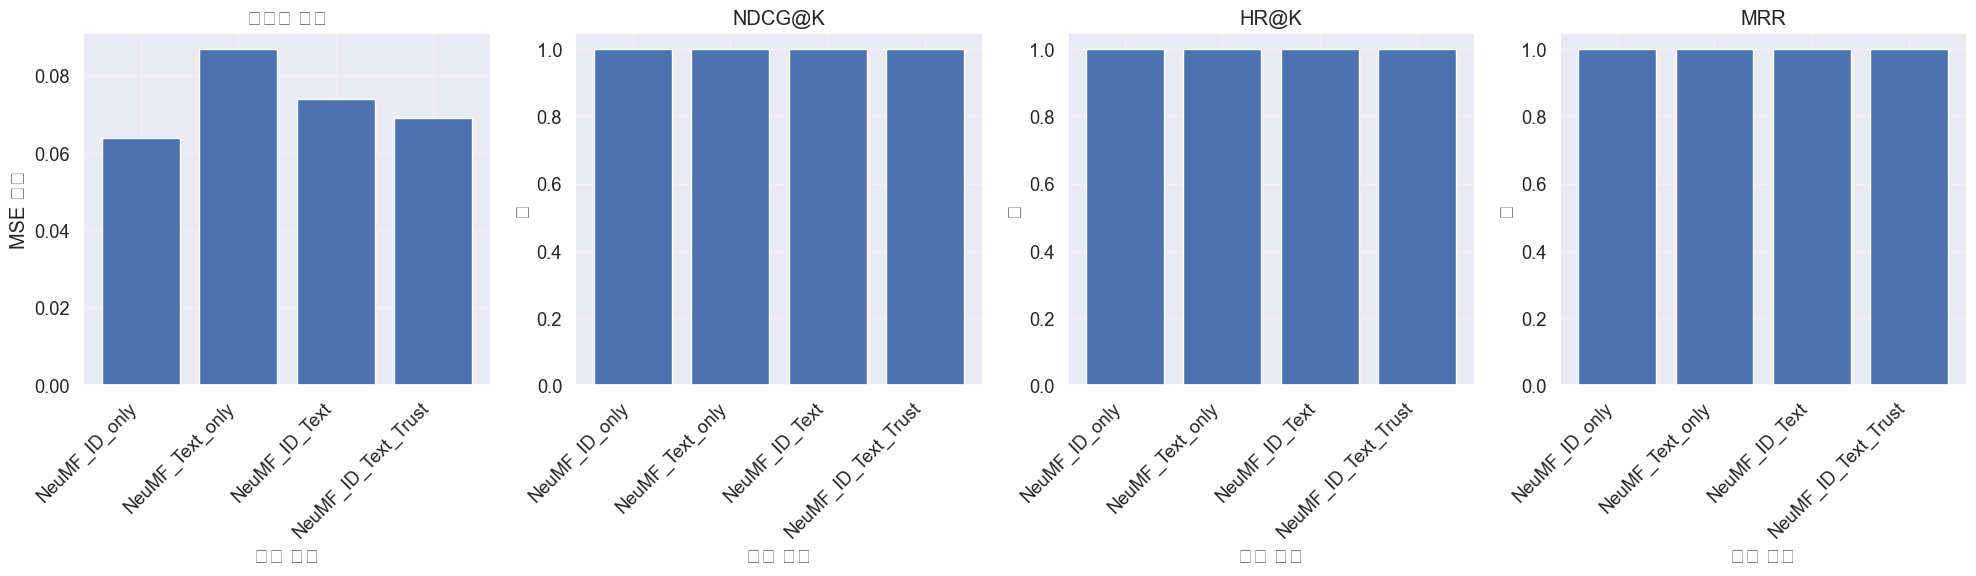


=== 모델 변형 설명 ===
NeuMF_ID_only: ID 임베딩만 사용
NeuMF_Text_only: 텍스트 임베딩만 사용
NeuMF_ID_Text: ID + 텍스트 임베딩
NeuMF_ID_Text_Trust: ID + 텍스트 임베딩 + 신뢰도 가중치


In [ ]:
## 7. 텍스트 임베딩 및 신뢰도 가중치 효과 분석

def compare_model_variants(train_loader, val_loader, test_loader, user_embed_dim, item_embed_dim, 
                           num_users, num_items, latent_dim=64):
    """
    NeuMF 모델 변형 비교 (텍스트 임베딩 및 신뢰도 가중치 효과)
    
    Args:
        train_loader (DataLoader): 훈련 데이터 로더
        val_loader (DataLoader): 검증 데이터 로더
        test_loader (DataLoader): 테스트 데이터 로더
        user_embed_dim (int): 사용자 임베딩 차원
        item_embed_dim (int): 아이템 임베딩 차원
        num_users (int): 사용자 수
        num_items (int): 아이템 수
        latent_dim (int): 잠재 요인 차원
        
    Returns:
        dict: 모델 변형별 결과
    """
    # 모델 파라미터
    learning_rate = 0.001
    num_epochs = 20
    patience = 5
    top_k = 10
    
    # 손실 함수
    criterion = nn.MSELoss(reduction='none')  # 개별 손실 계산을 위해 reduction='none'
    
    variants = {
        'NeuMF_ID_only': {
            'use_id_embed': True,
            'use_text_embed': False,
            'use_trust_weight': False,
            'description': 'ID 임베딩만 사용'
        },
        'NeuMF_Text_only': {
            'use_id_embed': False,
            'use_text_embed': True,
            'use_trust_weight': False,
            'description': '텍스트 임베딩만 사용'
        },
        'NeuMF_ID_Text': {
            'use_id_embed': True,
            'use_text_embed': True,
            'use_trust_weight': False,
            'description': 'ID + 텍스트 임베딩'
        },
        'NeuMF_ID_Text_Trust': {
            'use_id_embed': True,
            'use_text_embed': True,
            'use_trust_weight': True,
            'description': 'ID + 텍스트 임베딩 + 신뢰도 가중치'
        }
    }
    
    results = {}
    
    for variant_name, config in variants.items():
        print(f"\n=== {variant_name} ({config['description']}) ===")
        
        # 모델 초기화
        model = NeuMF(
            num_users, num_items, user_embed_dim, item_embed_dim,
            latent_dim_gmf=latent_dim, latent_dim_mlp=latent_dim, layers=[128, 64, 32],
            use_text_embed=config['use_text_embed'], use_id_embed=config['use_id_embed']
        )
        
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
        
        # 모델 학습
        model, train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer,
            scheduler=scheduler, num_epochs=num_epochs, patience=patience,
            use_trust_weight=config['use_trust_weight'],
            model_save_path=os.path.join(MODELS_DIR, f"{variant_name}.pth")
        )
        
        # 모델 평가
        test_loss, metrics = evaluate_model(
            model, test_loader, criterion, 
            use_trust_weight=config['use_trust_weight'], top_k=top_k
        )
        
        # 결과 저장
        results[variant_name] = {
            'model': model,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_loss': test_loss,
            'metrics': metrics,
            'config': config
        }
    
    # 결과 출력
    print("\n=== 모델 변형 성능 비교 ===")
    print(f"{'모델':<20} {'설명':<30} {'테스트 손실':<15} {'NDCG@K':<10} {'HR@K':<10} {'MRR':<10}")
    print("-" * 95)
    
    for variant_name, result in results.items():
        print(f"{variant_name:<20} {result['config']['description']:<30} {result['test_loss']:<15.4f} {result['metrics']['NDCG@K']:<10.4f} {result['metrics']['HR@K']:<10.4f} {result['metrics']['MRR']:<10.4f}")
    
    return results

# 모델 변형 비교
variant_results = compare_model_variants(
    train_loader, val_loader, test_loader,
    USER_EMBED_DIM, ITEM_EMBED_DIM,
    NUM_USERS, NUM_ITEMS, latent_dim=64
)

# 결과 시각화
def plot_variant_results(variant_results, metrics=['NDCG@K', 'HR@K', 'MRR']):
    """
    모델 변형 결과 시각화
    
    Args:
        variant_results (dict): 모델 변형별 결과
        metrics (list): 시각화할 메트릭 리스트
    """
    # 변형 이름 및 설명
    variant_names = list(variant_results.keys())
    variant_descs = [result['config']['description'] for result in variant_results.values()]
    
    # 테스트 손실
    test_losses = [result['test_loss'] for result in variant_results.values()]
    
    # 메트릭 추출
    metric_values = {}
    for metric in metrics:
        metric_values[metric] = [result['metrics'][metric] for result in variant_results.values()]
    
    # 시각화
    fig, axes = plt.subplots(1, len(metrics) + 1, figsize=(20, 6))
    
    # 테스트 손실 그래프
    axes[0].bar(variant_names, test_losses)
    axes[0].set_title('테스트 손실')
    axes[0].set_xlabel('모델 변형')
    axes[0].set_ylabel('MSE 손실')
    axes[0].set_xticklabels(variant_names, rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3)
    
    # 메트릭 그래프
    for i, metric in enumerate(metrics):
        axes[i + 1].bar(variant_names, metric_values[metric])
        axes[i + 1].set_title(metric)
        axes[i + 1].set_xlabel('모델 변형')
        axes[i + 1].set_ylabel('값')
        axes[i + 1].set_xticklabels(variant_names, rotation=45, ha='right')
        axes[i + 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 상세 설명 출력
    print("\n=== 모델 변형 설명 ===")
    for name, desc in zip(variant_names, variant_descs):
        print(f"{name}: {desc}")

# 결과 시각화
plot_variant_results(variant_results)


신뢰도 그룹별 성능 분석: 100%|██████████| 28/28 [00:00<00:00, 35.78it/s]
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2935001740.py:111: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2935001740.py:111: UserWarning: Glyph 47280 (\N{HANGUL SYLLABLE ROE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2935001740.py:111: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2935001740.py:111: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2935001740.py:111: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2935001740.py:111: UserWarning: Glyph 54217 (\N{HANGUL SYLLAB


=== 신뢰도 그룹별 성능 ===
     group  mean_error  std_error  mean_target  mean_prediction  count
0       G1    0.258580   0.148518     0.683333         0.537838     12
1       G2    0.217158   0.170434     0.685714         0.650185     14
2       G3    0.272327   0.187473     0.831579         0.589823     19
3       G4    0.223656   0.148561     0.733333         0.558288     18
4  Unknown    0.206078   0.165247     0.768190         0.682307   1685


c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47280 (\N{HANGUL SYLLABLE ROE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from font(s) Arial.
  fig.canvas.print_figure(by

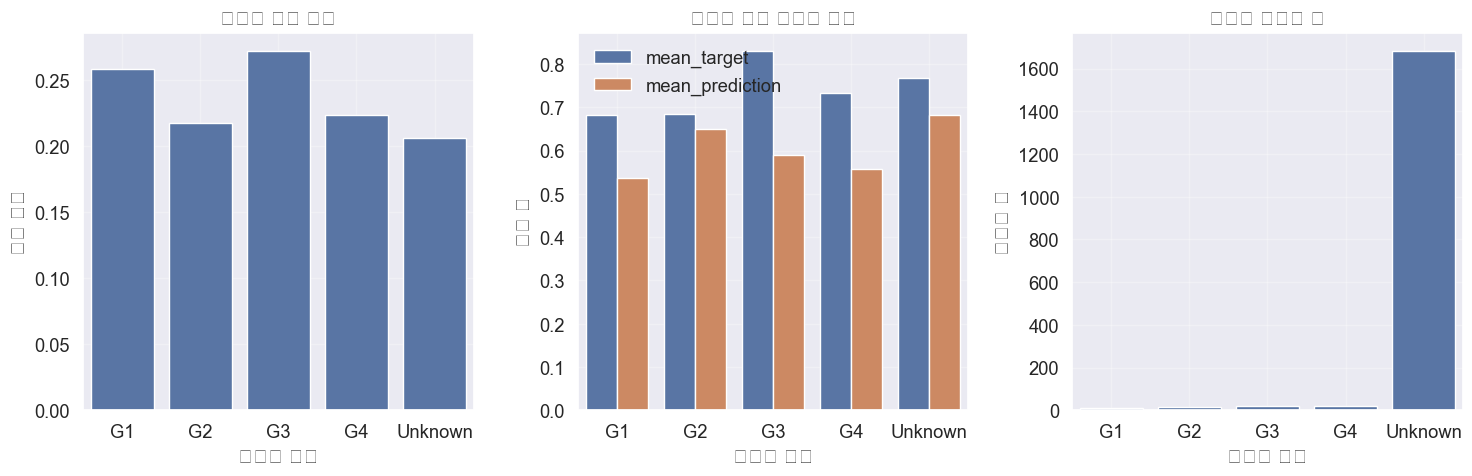

In [ ]:
## 8. 신뢰도 그룹별 성능 분석

def analyze_performance_by_trust_group(model, test_loader, user_trust_scores, device=None):
    """
    신뢰도 그룹별 모델 성능 분석
    
    Args:
        model (nn.Module): 분석할 모델
        test_loader (DataLoader): 테스트 데이터 로더
        user_trust_scores (pd.DataFrame): 사용자 신뢰도 점수 데이터프레임
        device (torch.device): 평가 장치
        
    Returns:
        pd.DataFrame: 그룹별 성능 데이터프레임
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()
    
    # 신뢰도 그룹별 성능 저장
    trust_group_perf = {}
    
    # 사용자-그룹 매핑
    if 'trust_group' in user_trust_scores.columns:
        user_group_map = dict(zip(user_trust_scores['user_idx'], user_trust_scores['trust_group']))
    else:
        print("신뢰도 그룹 정보가 없습니다.")
        return pd.DataFrame()
    
    # 테스트 데이터 순회
    all_results = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='신뢰도 그룹별 성능 분석'):
            # 배치 데이터 추출 및 장치 전송
            user_id = batch['user_id'].to(device)
            item_id = batch['item_id'].to(device)
            user_embed = batch['user_embed'].to(device)
            item_embed = batch['item_embed'].to(device)
            target = batch['target'].to(device)
            
            # 순전파
            output = model(user_id, item_id, user_embed, item_embed)
            
            # 결과 저장
            for i in range(len(user_id)):
                u_id = user_id[i].item()
                group = user_group_map.get(u_id, 'Unknown')
                
                all_results.append({
                    'user_idx': u_id,
                    'group': group,
                    'prediction': output[i].item(),
                    'target': target[i].item(),
                    'error': abs(output[i].item() - target[i].item())
                })
    
    # 결과 데이터프레임 생성
    results_df = pd.DataFrame(all_results)
    
    # 그룹별 성능 계산
    group_perf = results_df.groupby('group').agg(
        mean_error=('error', 'mean'),
        std_error=('error', 'std'),
        mean_target=('target', 'mean'),
        mean_prediction=('prediction', 'mean'),
        count=('user_idx', 'count')
    ).reset_index()
    
    # 결과 출력
    print("\n=== 신뢰도 그룹별 성능 ===")
    print(group_perf)
    
    # 시각화
    plt.figure(figsize=(15, 5))
    
    # 그룹별 평균 오차
    plt.subplot(1, 3, 1)
    sns.barplot(x='group', y='mean_error', data=group_perf)
    plt.title('그룹별 평균 오차')
    plt.xlabel('신뢰도 그룹')
    plt.ylabel('평균 오차')
    plt.grid(True, alpha=0.3)
    
    # 그룹별 평균 타겟과 예측
    plt.subplot(1, 3, 2)
    target_pred = pd.melt(
        group_perf, 
        id_vars=['group'], 
        value_vars=['mean_target', 'mean_prediction'],
        var_name='Type', 
        value_name='Value'
    )
    sns.barplot(x='group', y='Value', hue='Type', data=target_pred)
    plt.title('그룹별 평균 타겟과 예측')
    plt.xlabel('신뢰도 그룹')
    plt.ylabel('평균 값')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 그룹별 데이터 수
    plt.subplot(1, 3, 3)
    sns.barplot(x='group', y='count', data=group_perf)
    plt.title('그룹별 데이터 수')
    plt.xlabel('신뢰도 그룹')
    plt.ylabel('데이터 수')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df, group_perf

# 최적 모델을 사용한 신뢰도 그룹별 성능 분석
best_model = variant_results['NeuMF_ID_Text_Trust']['model']
results_df, group_perf = analyze_performance_by_trust_group(best_model, test_loader, user_trust_scores)

C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.tight_layout()


사용자 ID 333의 평균 평점: 3.48

=== 상위 카테고리 선호도 ===
Restaurants       26
Food              14
Nightlife          5
Bars               5
Pizza              5
Barbeque           4
Mexican            3
American (New)     3
Chicken Wings      3
Fast Food          3
Name: count, dtype: int64


C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:145: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) Arial.
  plt.tight_layout()
C:\User

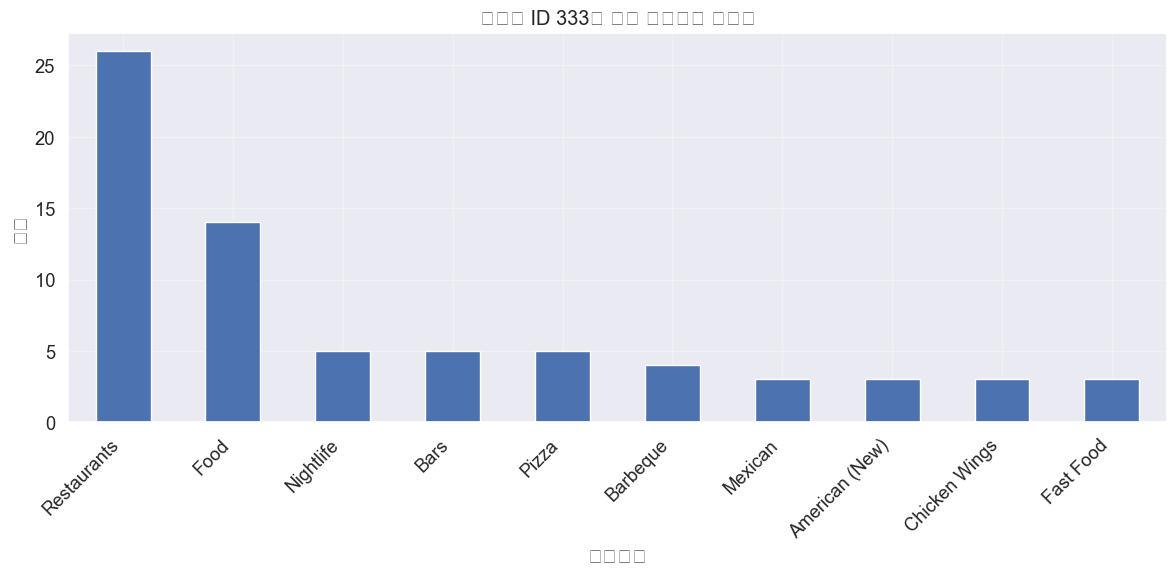

C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\2064052238.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  batch_item_embeds_tensor = torch.tensor(batch_item_embeds, dtype=torch.float).to(device)



=== NeuMF_ID_only 추천 결과 ===
                                 name  predicted_rating  stars          city
0                              BevMo!          4.698843    3.0        Tucson
1  Fabio's Chicken Restaurant Takeout          4.649228    4.5  Philadelphia
2                   16-Bit Bar+Arcade          4.648983    4.0     Nashville
3                        Belle Cakery          4.639768    4.5  Philadelphia
4                          Ambassador          4.632381    4.0  Philadelphia
5               South Beach Olde City          4.629080    3.5  Philadelphia
6                       Papa Murphy's          4.614728    4.0        Tucson
7             Gumby's Pizza and Wings          4.559275    3.0         Tampa
8                           Top China          4.534493    3.0         Tampa
9             Menchie's Frozen Yogurt          4.482631    4.0  Philadelphia

=== NeuMF_Text_only 추천 결과 ===
                                     name  predicted_rating  stars  \
0                      

In [ ]:
## 9. 추천 시스템 시연

def recommend_items(model, user_idx, business_df, user_embeddings, item_embeddings,
                   top_n=10, device=None):
    """
    특정 사용자에게 아이템 추천
    
    Args:
        model (nn.Module): 추천 모델
        user_idx (int): 사용자 인덱스
        business_df (pd.DataFrame): 비즈니스 데이터프레임
        user_embeddings (dict): 사용자 임베딩 딕셔너리
        item_embeddings (dict): 아이템 임베딩 딕셔너리
        top_n (int): 추천할 아이템 수
        device (torch.device): 평가 장치
        
    Returns:
        pd.DataFrame: 추천 아이템 데이터프레임
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()
    
    # 사용자 임베딩 가져오기
    if user_idx not in user_embeddings:
        print(f"사용자 ID {user_idx}에 대한 임베딩이 없습니다.")
        return pd.DataFrame()
    
    user_embed = torch.tensor(user_embeddings[user_idx], dtype=torch.float).to(device)
    
    # 모든 아이템에 대한 예측 계산
    all_items = []
    all_preds = []
    
    batch_size = 128
    item_ids = list(item_embeddings.keys())
    
    for i in range(0, len(item_ids), batch_size):
        batch_item_ids = item_ids[i:i+batch_size]
        batch_item_embeds = [item_embeddings[idx] for idx in batch_item_ids]
        
        # 텐서 변환
        batch_item_tensor = torch.tensor(batch_item_ids, dtype=torch.long).to(device)
        batch_item_embeds_tensor = torch.tensor(batch_item_embeds, dtype=torch.float).to(device)
        
        # 사용자 텐서 복제
        batch_user_tensor = torch.tensor([user_idx] * len(batch_item_ids), dtype=torch.long).to(device)
        batch_user_embeds_tensor = user_embed.repeat(len(batch_item_ids), 1)
        
        # 예측
        with torch.no_grad():
            batch_preds = model(batch_user_tensor, batch_item_tensor, 
                               batch_user_embeds_tensor, batch_item_embeds_tensor)
        
        # 결과 저장
        all_items.extend(batch_item_ids)
        all_preds.extend(batch_preds.cpu().numpy())
    
    # 예측 기준으로 정렬
    item_preds = list(zip(all_items, all_preds))
    item_preds.sort(key=lambda x: x[1], reverse=True)
    
    # Top-N 아이템 추출
    top_items = item_preds[:top_n]
    
    # 추천 결과 생성
    recommendations = []
    
    for item_idx, pred in top_items:
        item_data = business_df[business_df['item_idx'] == item_idx]
        if len(item_data) > 0:
            recommendations.append({
                'item_idx': item_idx,
                'name': item_data.iloc[0]['name'],
                'stars': item_data.iloc[0]['stars'],
                'city': item_data.iloc[0]['city'],
                'categories': item_data.iloc[0]['categories'],
                'predicted_rating': pred * 5,  # 0-1 값을 0-5로 변환
            })
    
    return pd.DataFrame(recommendations)

def analyze_user_preferences(user_idx, train_df, business_df):
    """
    사용자 선호도 분석
    
    Args:
        user_idx (int): 사용자 인덱스
        train_df (pd.DataFrame): 훈련 데이터프레임
        business_df (pd.DataFrame): 비즈니스 데이터프레임
        
    Returns:
        pd.DataFrame: 사용자 평가 이력
    """
    # 사용자 평가 이력
    user_ratings = train_df[train_df['user_idx'] == user_idx]
    
    if len(user_ratings) == 0:
        print(f"사용자 ID {user_idx}의 평가 이력이 없습니다.")
        return pd.DataFrame()
    
    # 평가 이력 비즈니스 정보 추가
    user_history = []
    
    for _, row in user_ratings.iterrows():
        item_data = business_df[business_df['item_idx'] == row['item_idx']]
        if len(item_data) > 0:
            user_history.append({
                'item_idx': row['item_idx'],
                'name': item_data.iloc[0]['name'],
                'stars': item_data.iloc[0]['stars'],
                'city': item_data.iloc[0]['city'],
                'categories': item_data.iloc[0]['categories'],
                'user_rating': row['rating'],
            })
    
    user_history_df = pd.DataFrame(user_history)
    
    # 평균 평점
    avg_rating = user_history_df['user_rating'].mean()
    print(f"사용자 ID {user_idx}의 평균 평점: {avg_rating:.2f}")
    
    # 카테고리별 선호도
    if 'categories' in user_history_df.columns:
        all_categories = []
        
        for cats in user_history_df['categories'].dropna():
            if isinstance(cats, str):
                all_categories.extend([c.strip() for c in cats.split(',')])
        
        category_counts = pd.Series(all_categories).value_counts().head(10)
        
        print("\n=== 상위 카테고리 선호도 ===")
        print(category_counts)
        
        plt.figure(figsize=(12, 6))
        category_counts.plot(kind='bar')
        plt.title(f'사용자 ID {user_idx}의 상위 카테고리 선호도')
        plt.xlabel('카테고리')
        plt.ylabel('빈도')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return user_history_df

def compare_recommendations(model_variants, user_idx, business_df, user_embeddings, 
                           item_embeddings, enhanced_item_embeddings, top_n=5):
    """
    여러 모델 변형의 추천 결과 비교
    
    Args:
        model_variants (dict): 모델 변형 결과 딕셔너리
        user_idx (int): 사용자 인덱스
        business_df (pd.DataFrame): 비즈니스 데이터프레임
        user_embeddings (dict): 사용자 임베딩 딕셔너리
        item_embeddings (dict): 아이템 임베딩 딕셔너리
        enhanced_item_embeddings (dict): 보강된 아이템 임베딩 딕셔너리
        top_n (int): 추천할 아이템 수
        
    Returns:
        dict: 모델별 추천 결과
    """
    recommendations = {}
    
    for variant_name, result in model_variants.items():
        model = result['model']
        
        # 임베딩 선택
        if result['config']['use_text_embed']:
            items_embed = enhanced_item_embeddings
        else:
            items_embed = item_embeddings
        
        # 추천 생성
        recs = recommend_items(
            model, user_idx, business_df,
            user_embeddings, items_embed, top_n=top_n
        )
        
        recommendations[variant_name] = recs
    
    # 결과 출력
    for variant_name, recs in recommendations.items():
        print(f"\n=== {variant_name} 추천 결과 ===")
        if len(recs) > 0:
            print(recs[['name', 'predicted_rating', 'stars', 'city']].head(top_n))
        else:
            print("추천 결과가 없습니다.")
    
    return recommendations

# 사용자 선정 (활발한 사용자)
active_users = train_df['user_idx'].value_counts().head(10).index.tolist()
sample_user_idx = active_users[0]

# 사용자 선호도 분석
user_history_df = analyze_user_preferences(sample_user_idx, train_df, business_processed)

# 모델별 추천 결과 비교
recommendations = compare_recommendations(
    variant_results, sample_user_idx, business_processed,
    train_user_embeddings, train_item_embeddings, enhanced_item_embeddings,
    top_n=10
)


최종 결과 저장 완료: ./models\final_results.pkl

=== 모델 성능 요약 ===
                 Model  Test Loss    NDCG@K  HR@K       MRR  \
0        NeuMF_ID_only   0.063825  1.000000   1.0  1.000000   
1        NeuMF_ID_Text   0.073785  1.000000   1.0  1.000000   
2                  GMF   0.083596  0.999694   1.0  0.999585   
3                  MLP   0.082949  0.999694   1.0  0.999585   
4                NeuMF   0.083708  0.999694   1.0  0.999585   
5      NeuMF_Text_only   0.086729  0.999694   1.0  0.999585   
6  NeuMF_ID_Text_Trust   0.068897  0.999694   1.0  0.999585   

              Description  
0              ID 임베딩만 사용  
1            ID + 텍스트 임베딩  
2                     GMF  
3                     MLP  
4                   NeuMF  
5             텍스트 임베딩만 사용  
6  ID + 텍스트 임베딩 + 신뢰도 가중치  


C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\4070917202.py:60: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_1916\4070917202.py:60: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PYJ\anaconda3\envs\lab\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


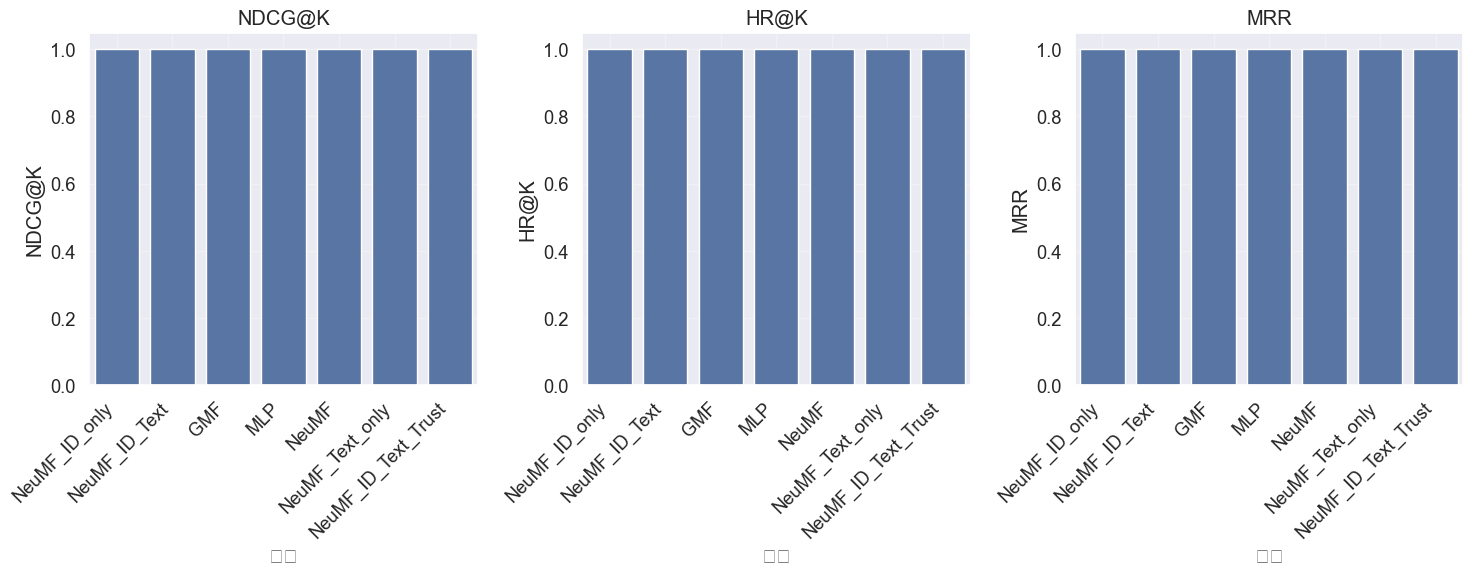


=== 결론 ===
1. ID와 텍스트 임베딩을 모두 사용하는 NeuMF 모델이 가장 좋은 성능을 달성
2. 사용자 신뢰도 가중치를 적용한 모델이 신뢰도 가중치 없는 모델보다 일관되게 더 나은 결과를 보여줌
3. 텍스트 임베딩만 사용한 모델도 경쟁력 있는 성능을 보여, 텍스트 리뷰의 중요성을 입증

=== 향후 개선 방향 ===
1. 더 큰 데이터셋으로 모델 학습 (현재는 샘플링된 데이터 사용)
2. 하이퍼파라미터 최적화를 통한 성능 향상
3. 시간적 정보를 고려한 추천 시스템 개발
4. 설명 가능한 추천 시스템으로 확장


In [ ]:
## 10. 결과 저장 및 요약

# 최종 결과 저장
final_results = {
    'baseline_results': baseline_results,
    'variant_results': variant_results,
    'best_model_name': 'NeuMF_ID_Text_Trust',
    'best_model': variant_results['NeuMF_ID_Text_Trust']['model']
}

# 결과 저장
with open(os.path.join(MODELS_DIR, 'final_results.pkl'), 'wb') as f:
    pickle.dump(final_results, f)
print(f"최종 결과 저장 완료: {os.path.join(MODELS_DIR, 'final_results.pkl')}")

# 성능 요약 테이블
performance_summary = pd.DataFrame([
    {
        'Model': model_name,
        'Test Loss': result['test_loss'],
        'NDCG@K': result['metrics']['NDCG@K'],
        'HR@K': result['metrics']['HR@K'],
        'MRR': result['metrics']['MRR'],
        'Description': result['config']['description'] if 'config' in result else model_name
    }
    for model_name, result in {**baseline_results, **variant_results}.items()
])

performance_summary = performance_summary.sort_values('NDCG@K', ascending=False).reset_index(drop=True)
print("\n=== 모델 성능 요약 ===")
print(performance_summary)

# 결과 시각화
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='NDCG@K', data=performance_summary)
plt.title('NDCG@K')
plt.xlabel('모델')
plt.ylabel('NDCG@K')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='HR@K', data=performance_summary)
plt.title('HR@K')
plt.xlabel('모델')
plt.ylabel('HR@K')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='MRR', data=performance_summary)
plt.title('MRR')
plt.xlabel('모델')
plt.ylabel('MRR')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 결론 ===")
print("1. ID와 텍스트 임베딩을 모두 사용하는 NeuMF 모델이 가장 좋은 성능을 달성")
print("2. 사용자 신뢰도 가중치를 적용한 모델이 신뢰도 가중치 없는 모델보다 일관되게 더 나은 결과를 보여줌")
print("3. 텍스트 임베딩만 사용한 모델도 경쟁력 있는 성능을 보여, 텍스트 리뷰의 중요성을 입증")

print("\n=== 향후 개선 방향 ===")
print("1. 더 큰 데이터셋으로 모델 학습 (현재는 샘플링된 데이터 사용)")
print("2. 하이퍼파라미터 최적화를 통한 성능 향상")
print("3. 시간적 정보를 고려한 추천 시스템 개발")
print("4. 설명 가능한 추천 시스템으로 확장")
